In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mi = 30
lambda_ = 20

size_y = 4
size_x = 20

bounding_box = np.array([0, 5, 0, 1])

In [9]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    result = np.zeros_like(x)
    cond = (1 <= x) & (x <= 4) & (1 / 4 <= y) & (y <= 3 / 4)
    result[cond] = 0
    return result


def f2(x, y):
    x = np.array(x)
    y = np.array(y)
    result = np.zeros_like(x)
    cond = (1 <= x) & (x <= 4) & (1 / 4 <= y) & (y <= 3 / 4)
    result[cond] = -1
    return result

In [10]:
x = np.linspace(bounding_box[0], bounding_box[1], size_x + 1)
y = np.linspace(bounding_box[2], bounding_box[3], size_y + 1)
vertices = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

In [11]:
boundary = np.where((vertices[:, 0] == bounding_box[0]) | (vertices[:, 0] == bounding_box[1]))[0]
elements = np.array(
    [np.array([i, i + 1, i + 2 + size_x, i + 1 + size_x]) + (j * (size_x + 1)) for j in range(size_y) for i in
     range(size_x)])

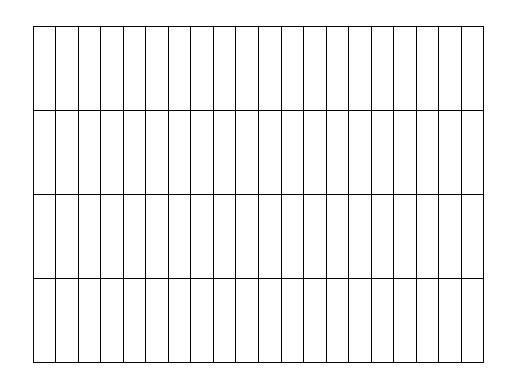

In [12]:
fig = plt.figure()
for element in elements:
    x = [vertices[x][0] for x in element]
    x.append(x[0])
    y = [vertices[x][1] for x in element]
    y.append(y[0])
    plt.plot(x, y, c="black", linewidth=0.7)
plt.axis('off')
# plt.savefig('mesh.png')
plt.show()

In [13]:
A = np.zeros((len(vertices) * 2, len(vertices) * 2))
F = np.zeros(len(vertices) * 2)
u = np.zeros(len(vertices) * 2)

for element in elements:
    local_vertices = vertices[element]
    x = local_vertices[:, 0]
    y = local_vertices[:, 1]
    n_of_sides = len(element)
    range_plus_one = np.array([*range(1, n_of_sides), 0])
    area_part = np.array([x[i] * y[j] - x[j] * y[i] for i, j in zip(range(n_of_sides), range_plus_one)])
    area = np.abs(1 / 2 * np.sum(area_part))
    centroid = 1 / (6 * area) * np.sum([(d + d[range_plus_one]) * area_part for d in [x, y]], axis=1)

    B_snake_x = np.zeros((6, n_of_sides))
    B_snake_y = np.zeros((6, n_of_sides))

    Mxx = np.ones((n_of_sides, n_of_sides)) / (4 * area)
    Myx = np.ones((n_of_sides, n_of_sides)) / (4 * area)
    Myy = np.ones((n_of_sides, n_of_sides)) / (4 * area)

    B_snake_x[0, :] = 1
    B_snake_x[1, :] = 0
    B_snake_y[0, :] = 0
    B_snake_y[1, :] = 1
    vertex_hat_normals = []
    vertex_hat_lengths = []
    for vertex_id in range(n_of_sides):
        vert = local_vertices[vertex_id]
        previous = local_vertices[vertex_id - 1]
        next = local_vertices[(vertex_id + 1) % n_of_sides]
        vertex_hat_normal = np.array([next[1] - previous[1], previous[0] - next[0]])
        vertex_hat_normals.append(vertex_hat_normal)
        length = np.linalg.norm(next - previous)
        vertex_hat_lengths.append(length)
        B_snake_x[2, vertex_id] = -vert[1]
        B_snake_x[3, vertex_id] = vertex_hat_normal[1] * length * mi
        B_snake_x[4, vertex_id] = vertex_hat_normal[0] * length * mi
        B_snake_x[5, vertex_id] = vertex_hat_normal[0] * length * (mi + lambda_)
        B_snake_y[2, vertex_id] = vert[0]
        B_snake_y[3, vertex_id] = vertex_hat_normal[0] * length * mi
        B_snake_y[4, vertex_id] = -vertex_hat_normal[1] * length * mi
        B_snake_y[5, vertex_id] = vertex_hat_normal[1] * length * (mi + lambda_)

    # for j in range(n_of_sides):
    #     Mxx[:, j] *= vertex_hat_lengths[j] * vertex_hat_normals[j][0]
    #     Myx[:, j] *= vertex_hat_lengths[j] * vertex_hat_normals[j][0]
    #     Myy[:, j] *= vertex_hat_lengths[j] * vertex_hat_normals[j][1]

    G = np.zeros((6, 6))
    G[3,3] = 4 * mi * area
    G[4,4] = 4 * mi * area
    G[5,5] = 4 * (mi + lambda_) * area
    G_snake = G.copy()
    Sx = np.sum(local_vertices[:, 0])
    Sy = np.sum(local_vertices[:, 1])
    Sx2 = np.sum(local_vertices[:, 0] ** 2)
    Sy2 = np.sum(local_vertices[:, 1] ** 2)
    Sxy = np.sum(local_vertices[:, 0] * local_vertices[:, 1])
    G_snake[0, :] = np.array(
        [n_of_sides, 0, -Sy + n_of_sides * centroid[1], Sy - n_of_sides * centroid[1], Sx - n_of_sides * centroid[0],
         Sx - n_of_sides * centroid[0]])
    G_snake[1, :] = np.array(
        [0, n_of_sides, Sx - n_of_sides * centroid[0], Sx - n_of_sides * centroid[0], -Sy + n_of_sides * centroid[1],
         Sy - n_of_sides * centroid[1]])
    G_snake[2, :] = np.array(
        [-Sy, Sx, Sx2 + Sy2 - Sx * centroid[0] - Sy * centroid[1], Sx2 - Sy2 - Sx * centroid[0] + Sy * centroid[1],
         -2 * Sxy + Sx * centroid[1] + Sy * centroid[0], - Sx * centroid[1] + Sy * centroid[0]])
    projector_x = np.linalg.solve(G_snake, B_snake_x)
    projector_y = np.linalg.solve(G_snake, B_snake_y)

    D = np.zeros((2 * n_of_sides, 6))
    for i in range(n_of_sides):
        x = local_vertices[i, 0]
        y = local_vertices[i, 1]
        D[i] = np.array([1, 0, -y + centroid[1], y - centroid[1], x - centroid[0], x - centroid[0]])
        D[i + n_of_sides] = np.array([0, 1, x - centroid[0], x - centroid[0], -y + centroid[1], y - centroid[1]])

    Al_x = np.zeros((2 * n_of_sides, n_of_sides))
    Al_y = np.zeros((2 * n_of_sides, n_of_sides))

    Al_x[:n_of_sides] = np.eye(n_of_sides)
    Al_y[n_of_sides:] = np.eye(n_of_sides)
    part_x = Al_x - (D @ projector_x)
    part_y = Al_y - (D @ projector_y)

    stabilizing_term_xx = part_x.T @ part_x
    stabilizing_term_yx = part_x.T @ part_y
    stabilizing_term_yy = part_y.T @ part_y

    local_stiffness_mi_xx = ((projector_x.T @ G) @ projector_x)
    local_stiffness_mi_yx = ((projector_x.T @ G) @ projector_y)
    local_stiffness_mi_yy = ((projector_y.T @ G) @ projector_y)

    A[np.ix_(element, element)] += local_stiffness_mi_xx + (2*mi + lambda_)* stabilizing_term_xx
    A[np.ix_(element + len(vertices),
             element + len(vertices))] += local_stiffness_mi_yy + (2 * mi + lambda_) * stabilizing_term_yy
    A[np.ix_(element, element + len(vertices))] += local_stiffness_mi_yx + (2 * mi + lambda_) * stabilizing_term_yx

    F[element] += f1(centroid[0], centroid[1]) * area / n_of_sides
    F[element + len(vertices)] += f2(centroid[0], centroid[1]) * area / n_of_sides
A[len(vertices):,:len(vertices)] = A[:len(vertices),len(vertices):].T
internal_vertices = np.tile(~np.isin(np.arange(len(vertices)), boundary),2)

# u[internal_vertices] = np.linalg.solve(A[np.ix_(internal_vertices, internal_vertices)], F[internal_vertices] - A[
#     np.ix_(np.where(internal_vertices)[0], np.where(~internal_vertices)[0])] @ np.zeros(len(boundary)*2))
u[internal_vertices] = np.linalg.solve(A[np.ix_(internal_vertices, internal_vertices)], F[internal_vertices])
u[~internal_vertices] = 0

In [22]:
import scipy
u2 = np.zeros_like(u)
Ai = A[np.ix_(internal_vertices, internal_vertices)]
Fi = F[internal_vertices]
from autograd import grad
def functional(x):
    return 1/2*(np.dot(x, np.dot(Ai,x))) - Fi @ x
functional_grad = grad(functional)
res = scipy.optimize.minimize(functional, np.zeros_like(Fi), method='BFGS', options={"disp": True})
u2[internal_vertices] = res.x

Optimization terminated successfully.
         Current function value: -0.134635
         Iterations: 120
         Function evaluations: 27504
         Gradient evaluations: 144


In [23]:
print(np.linalg.eigvals(A))

[ 3.01179281e+02  2.97402315e+02  2.93974364e+02  2.91688115e+02
  2.91207855e+02  2.87917385e+02  2.82745710e+02  2.82725272e+02
  2.76205975e+02  2.72224537e+02  2.68488351e+02  2.59913336e+02
  2.59742833e+02  2.55719006e+02  2.52227657e+02  2.50191617e+02
  2.46472170e+02  2.46151483e+02  2.40244359e+02  2.38435570e+02
  2.31420560e+02  2.30111274e+02  2.28358501e+02  2.27916029e+02
  2.25976798e+02  2.22622487e+02  2.15523403e+02  2.17355265e+02
  2.19188100e+02  2.18630779e+02  2.12440550e+02  2.08005142e+02
  2.05440967e+02  2.05216566e+02  2.01793834e+02  2.01505772e+02
  1.92261988e+02  1.93602105e+02  1.95851437e+02  1.98707568e+02
  1.97485056e+02  1.90066546e+02  1.87785059e+02  1.86593841e+02
  1.83296559e+02  1.78000308e+02  1.78251903e+02  1.79558007e+02
  1.79058738e+02  1.71512582e+02  1.70229722e+02  1.68045402e+02
  1.68296625e+02  1.65497871e+02  1.63720198e+02  1.60877068e+02
  1.58248864e+02  1.56972897e+02  1.56275182e+02  1.58078039e+02
  3.53124546e+00  3.03876

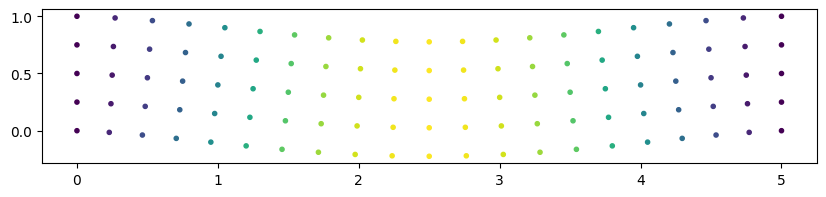

In [21]:
plt.figure(figsize=(10,2))
x = vertices[:,0].copy()
y = vertices[:,1].copy()
delta_x = u[:len(vertices)].copy()
delta_y = u[len(vertices):].copy()
c = np.sqrt(delta_x ** 2 + delta_y ** 2)
x += delta_x
y += delta_y
plt.scatter(x,y, marker='.', cmap='viridis', c=c)
# plt.savefig('plotVEMNewWith2MIForce100.png')


In [33]:
print(projector_x)


[[ 2.50000000e-01  2.50000000e-01  2.50000000e-01  2.50000000e-01]
 [-1.22568142e-12 -1.22568120e-12  1.22568165e-12  1.22568142e-12]
 [ 5.00000000e+00  5.00000000e+00 -5.00000000e+00 -5.00000000e+00]
 [-3.53553391e-01 -3.53553391e-01  3.53553391e-01  3.53553391e-01]
 [-3.53553391e-01  3.53553391e-01  3.53553391e-01 -3.53553391e-01]
 [-3.53553391e-01  3.53553391e-01  3.53553391e-01 -3.53553391e-01]]


In [51]:
print(stabilizing_term_xx)


[[ 0.57384199 -0.35794733 -0.07384199 -0.14205267]
 [-0.35794733  0.57384199 -0.14205267 -0.07384199]
 [-0.07384199 -0.14205267  0.57384199 -0.35794733]
 [-0.14205267 -0.07384199 -0.35794733  0.57384199]]
